### Optimization of 2-D Rosenbrock function for varied coefficients

Reference: https://en.wikipedia.org/wiki/Rosenbrock_function

$$ cost(a,b,x,y) =  b (y-x)^2 + (x-a)^2 ,$$
$$pdf(a,b,x,y) = e^{-cost(a,b,x,y)}$$ 

Here, $\mathbf{x}_{task}=(a,b)$ and $\mathbf{x}_{decision} = (x,y)$

The global optima is unique: $(a,a^2)$

We show that TTGO is able to find the global optima consistently with a hand few of samples from the constructed tt-model of the above pdf (constructed offline) for various selection of $\mathbf{x}_{task}$ in the online phase.  We use scipy's SLSQP to fine tune the initialization. 

Condition on different values of $\mathbf{x}_{task}=(a,b)$ to test the model.

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('./fcn_opt')
sys.path.append('../')

from ttgo import TTGO
from test_fcns import Rosenbrock_4D 
from fcn_plotting_utils import plot_surf, plot_contour

%load_ext autoreload
np.set_printoptions(precision=3)
%autoreload 2

### Define the function

In [2]:
pdf, cost =  Rosenbrock_4D(alpha=1)

### Define the domain and the discretization

In [3]:
# Define the domain of the function

L = 2 # [-L,L]^2 is the domain of the function

# domain of task params: domain of coefficients a and b in Rosenbrock_4D
# Note: a should in (-sqrt(L), sqrt(L)) 
domain_task = [torch.linspace(-1.5,1.5,500)]+[torch.linspace(50,150,500)] 
# domain of decison varibales
domain_decision = [torch.linspace(-L,L,500)]*2
domain = domain_task+domain_decision

### Fit the TT-Model

In [4]:
ttgo = TTGO(domain=domain,pdf=pdf,cost=cost)

In [5]:
ttgo.cross_approximate(rmax=500, nswp=10, kickrank=3, eps=1e-6)

cross device is cpu
Cross-approximation over a 4D domain containing 6.25e+10 grid points:
Note: The algorithm converges as the ratio tt-new-norm/tt-old-norm settles to 1. For TTGO, the convergence is not important, just keep iterating as long as the ratio > 1
iter: 0  | tt-new-norm/tt-old-norm: 5.097e-02 | time:   0.0104 | largest rank:   1
iter: 1  | tt-new-norm/tt-old-norm: 1.018e+00 | time:   0.0252 | largest rank:   4
iter: 2  | tt-new-norm/tt-old-norm: 1.515e+00 | time:   0.0418 | largest rank:   7
iter: 3  | tt-new-norm/tt-old-norm: 8.979e-01 | time:   0.0694 | largest rank:  10
iter: 4  | tt-new-norm/tt-old-norm: 1.096e+00 | time:   0.0986 | largest rank:  13
iter: 5  | tt-new-norm/tt-old-norm: 1.049e+00 | time:   0.1457 | largest rank:  16
iter: 6  | tt-new-norm/tt-old-norm: 1.014e+00 | time:   0.2098 | largest rank:  19
iter: 7  | tt-new-norm/tt-old-norm: 1.044e+00 | time:   0.2967 | largest rank:  22
iter: 8  | tt-new-norm/tt-old-norm: 1.036e+00 | time:   0.4053 | largest ran

In [6]:
sites_task = torch.tensor([0,1]) # sites to be consitioned upon (task-params)
ttgo.set_sites(sites_task)
ttgo.round(eps=1e-9)
print("TT-Rank: ", ttgo.tt_model.ranks_tt)

TT-Rank:  tensor([ 1, 13, 28, 28,  1])


In [7]:
# torch.save([ttgo.tt_model,domain],'rosen4D.pickle')

### Sample from TT-Model

In [8]:
x_task = torch.tensor([0.25,140.]).view(1,-1) #given task-parameters
n_samples_tt = 1000
samples, samples_idx = ttgo.sample(n_samples=n_samples_tt, x_task=x_task.view(1,-1), alpha=0., norm=1) 

### Choose the best sample as an estimate for optima

In [9]:
best_estimate = ttgo.choose_best_sample(samples)
ttgo_optimized, _ = ttgo.optimize(best_estimate)

##### Fine-tune the estimate using gradient-based optimization

In [10]:
print("PDF at the estimated point: ", pdf(best_estimate))
print("PDF at the optima: ", pdf(ttgo_optimized))

PDF at the estimated point:  tensor([0.9996])
PDF at the optima:  tensor([0.9996])


In [11]:
print("Estimated Optima: ", best_estimate)
print("Optima: ", ttgo_optimized)

Estimated Optima:  tensor([[2.4950e-01, 1.3998e+02, 2.2846e-01, 5.2104e-02]])
Optima:  tensor([[2.4950e-01, 1.3998e+02, 2.2990e-01, 5.3264e-02]])


### Visualization

In [12]:
# Redefinig the function given the coefficients
def cost_fcn(X):
    X = torch.from_numpy(X)
    X_ext = torch.empty(X.shape[0],4)
    X_ext[:,:2] = x_task
    X_ext[:,2:] = X
    return cost(X_ext).numpy()
    


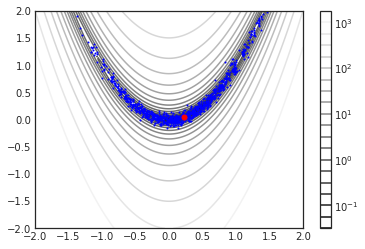

In [13]:
data = samples[:,2:]
x = np.linspace(-L,L,200)
y = np.linspace(-L,L,200)

plt=plot_contour(x,y,cost_fcn,data=data, contour_scale=500, figsize=5, markersize=1)
plt.plot(ttgo_optimized[:,2],ttgo_optimized[:,3],'.r',markersize=10)
# plt.savefig('rosenbrock4D_a25_b140_alpha0_ns1000_k1.png',pad_inches=0.01, dpi=300)


In [14]:
# plt = plot_surf(x,y,cost_fcn,data=data,zlim=(0,2000),figsize=10, view_angle=(45,45),markersize=3)